# HEALpixel functions 

Two main packages are available for manipulating HEALpixel maps: Astropy's astropy_healpix and healpy.  

In [1]:
import healpy as hp
from astropy_healpix import HEALPix
from astropy import units as u
from astropy.coordinates import Galactic, SkyCoord, TETE
import numpy as np
from mw_plot import MWSkyMap
import matplotlib.pyplot as plt
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
import regions
import config_utils
import survey_footprints

In [2]:
# Example query parameters; all units in degrees
l_center = 0.0
b_center = 0.0
radius = 1.0

NSIDE = 256
NPIX = hp.nside2npix(NSIDE)

In [3]:
# Use Astropy functions to calculate the HEALpixels that lie within the circular region
# RING orientation is used since this is the HEALpy default 
ahp = HEALPix(nside=NSIDE, order='ring', frame=Galactic())

pixels1 = ahp.cone_search_lonlat(
                l_center * u.deg,
                b_center * u.deg,
                radius=radius * u.deg
            )
print(pixels1, len(pixels1))

map1 = np.zeros(NPIX)
map1[pixels1] = 1.0

[391680 390656 389632 391679 392703 393727 393728 392704 391681 390657
 389633 393729 392705 391682 390658 389634 393730 392706 391683 389635
 393731 394754 395779 395778 396802 396801 397826 397825 398849 398848
 399873 399872 397824 399871 400895 398847 399870 397822 398846 396798
 397821 395773 396797 394749 393725 392701 394750 393726 392702 395774
 394751 396799 395775 397823 395776 394752 396800 395777 394753 391678
 390654 391677 389629 390653 388606 389630 388607 387582 390655 389631
 387584 387583 388608 387585 386560 388609 387586 386561 388610 385537
 385536 386559] 82


/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_3532/2191992610.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x1000 with 0 Axes>

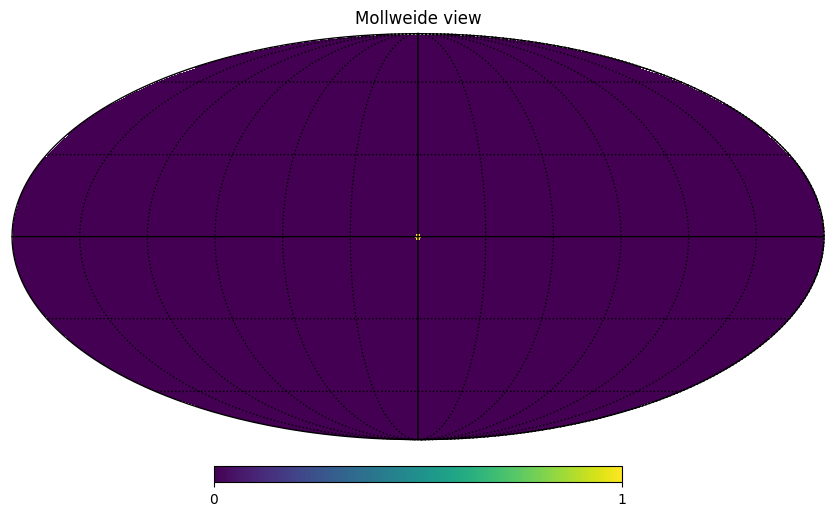

In [4]:
fig = plt.figure(1,(10,10))
hp.mollview(map1)
hp.graticule()
plt.tight_layout()

In [5]:
plt.close()

In [6]:
# Using HEALpy to perform an equivalent HEALpixel cone search
s = SkyCoord(
    l_center,
    b_center,
    frame=Galactic(),
    unit=(u.deg, u.deg)
)
print(s)
s = s.transform_to('icrs')
print(s)

phi = np.deg2rad(s.ra.deg)
theta = (np.pi / 2.0) - np.deg2rad(s.dec.deg)
r = np.deg2rad(radius)
print(phi, theta, r)

xyz = hp.ang2vec(theta, phi)
print(NSIDE, xyz)
pixels2 = hp.query_disc(NSIDE, xyz, r)

print(pixels2, len(pixels2))

map2 = np.zeros(NPIX)
map2[pixels2] = 1.0

<SkyCoord (Galactic): (l, b) in deg
    (0., 0.)>
<SkyCoord (ICRS): (ra, dec) in deg
    (266.40498829, -28.93617776)>
4.649644189337132 2.0758279016805212 0.017453292519943295
256 [-0.05487566 -0.87343705 -0.48383507]
[577781 578804 578805 578806 578807 579827 579828 579829 579830 579831
 580851 580852 580853 580854 580855 580856 581875 581876 581877 581878
 581879 581880 582899 582900 582901 582902 582903 582904 583923 583924
 583925 583926 583927 583928 584947 584948 584949 584950 584951 584952
 585971 585972 585973 585974 585975 585976 586996 586997 586998 586999
 587000 588020 588021 588022 588023 589045 589046 589047] 58


/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_3532/3680801913.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x1000 with 0 Axes>

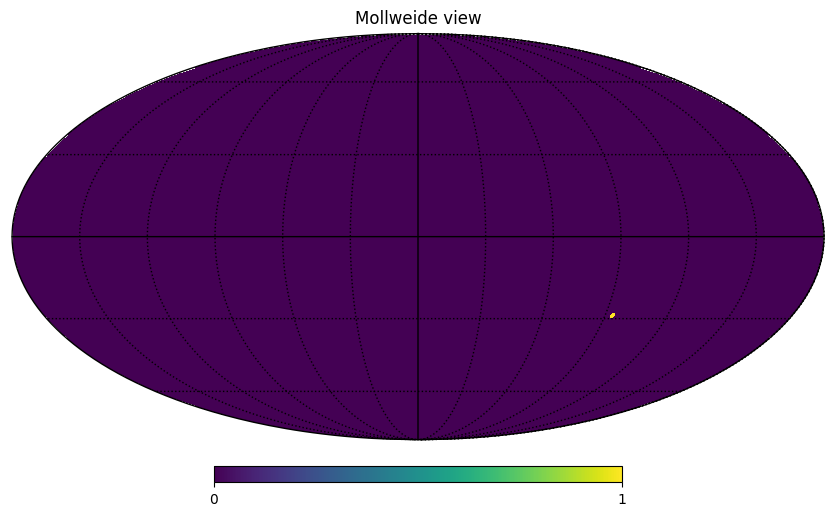

In [7]:
fig = plt.figure(1,(10,10))
hp.mollview(map2)
hp.graticule()
plt.tight_layout()

By default HEALpy produces a map in equatorial coordinates.  These can be rotated to return to Galactic coordinates.

In [8]:
def rotateHealpix(hpmap, transf=['C','G'], phideg=0., thetadeg=0.):
    """Rotates healpix map from one system to the other. Returns reordered healpy map.
    Healpy coord transformations are used, or you can specify your own angles in degrees.
    To specify your own angles, ensure that transf has length != 2.
    Original code by Xiaolong Li
    """

    # For reasons I don't understand, entering in ['C', 'G'] seems to do the
    # transformation FROM galactic TO equatorial. Possibly something buried in
    # the conventions used by healpy.

    # Heavily influenced by stack overflow solution here:
    # https://stackoverflow.com/questions/24636372/apply-rotation-to-healpix-map-in-healpy

    nside = hp.npix2nside(len(hpmap))

    # Get theta, phi for non-rotated map
    t,p = hp.pix2ang(nside, np.arange(hp.nside2npix(nside)))

    # Define a rotator
    if len(transf) == 2:
        r = hp.Rotator(coord=transf)
    else:
        r = hp.Rotator(deg=True, rot=[phideg,thetadeg])

    # Get theta, phi under rotated co-ordinates
    trot, prot = r(t,p)

    # Interpolate map onto these co-ordinates
    rot_map = hp.get_interp_val(hpmap, trot, prot)

    return rot_map

In [9]:
map3 = rotateHealpix(map2, transf=['G','C'])

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_3532/4037056415.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x1000 with 0 Axes>

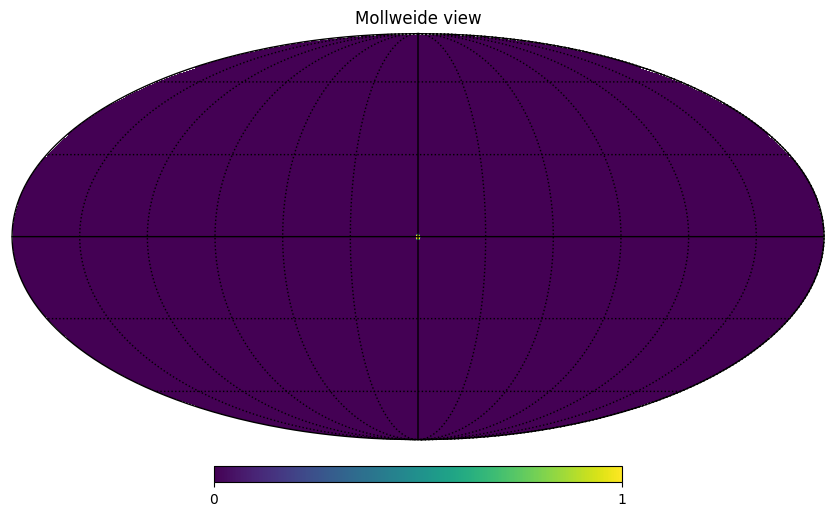

In [10]:
fig = plt.figure(1,(10,10))
hp.mollview(map3)
hp.graticule()
plt.tight_layout()

In [11]:
pixels3 = np.where(map3 > 0.0)[0]
print(pixels3, len(pixels3))

[384512 385535 385536 385537 386559 386560 386561 387582 387583 387584
 387585 387586 388606 388607 388608 388609 388610 389629 389630 389631
 389632 389633 389634 389635 390654 390655 390656 390657 390658 391677
 391678 391679 391680 391681 391682 391683 392701 392702 392703 392704
 392705 392706 393725 393726 393727 393728 393729 393730 393731 394749
 394750 394751 394752 394753 394754 395773 395774 395775 395776 395777
 395778 396798 396799 396800 396801 396802 397821 397822 397823 397824
 397825 397826 398846 398847 398848 398849 399870 399871 399872 399873
 400895 400896] 82


Check this works as expected with CelestialRegions

In [13]:
test_case = {"TEST": {
                "F213": [
                {"pointing": [0.0, 0.0, 2.0],
                "nvisits": 60,
                "duration": 0.4,
                "visit_interval": [0.13],
                "name": "NGC6528"},
                ],
                "region": "Test field",
                "comment": "Test",
                "proper_motions": "False",
                "time_domain": "True",
                "cadence": "1min over 8hrs",
                "n_visits_per_field": 60,
                "category": "high_cadence",
                "ready_for_use": "True",
                "extended_object_catalog": "False",
                "code": "WPXX",
                "topics": ["None"]
                }
            }
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))
test_science_cases = regions.build_region_maps(sim_config, test_case)
print(test_science_cases)
r = test_science_cases['TEST']['F213'][0]

{'TEST': {'F062': [], 'F087': [], 'F106': [], 'F129': [], 'F158': [], 'F184': [], 'F213': [<regions.CelestialRegion object at 0x12488fd90>], 'F146': [], 'G150': [], 'P127': []}}


/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_3532/2277566355.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x1000 with 0 Axes>

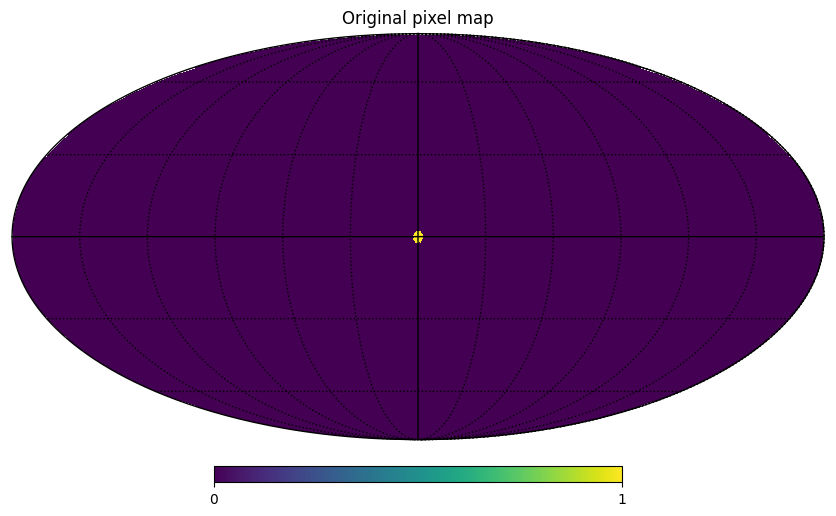

In [14]:
fig = plt.figure(1,(10,10))
hp.mollview(r.region_map, title='Original pixel map')
hp.graticule()
plt.tight_layout()

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_3532/1481901782.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x1000 with 0 Axes>

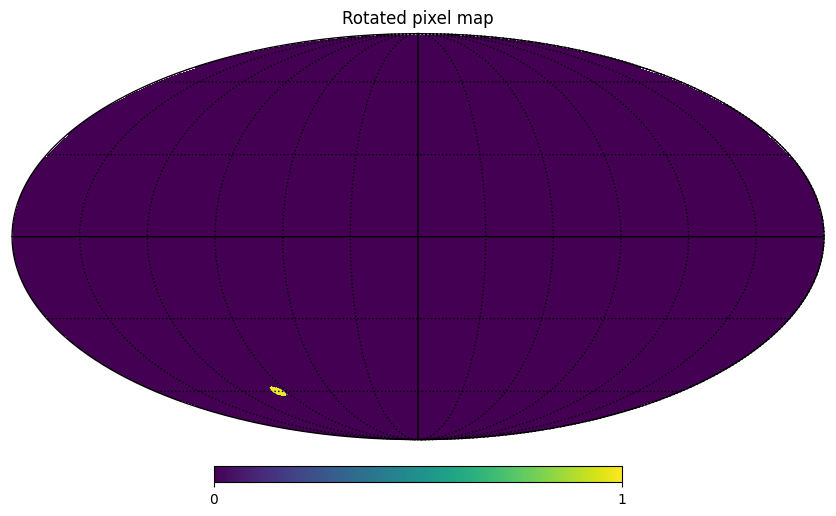

In [15]:
r.rot_pixels()

fig = plt.figure(1,(10,10))
hp.mollview(r.region_map, title='Rotated pixel map')
hp.graticule()
plt.tight_layout()

Test loading of survey footprints

In [16]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

rubin_map = survey_footprints.load_rubin_galplane_footprint(sim_config, '/Users/rstreet/software/rgps/')
rubin_map

array([0., 0., 0., ..., 0., 0., 0.])

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_3532/3091875413.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x1000 with 0 Axes>

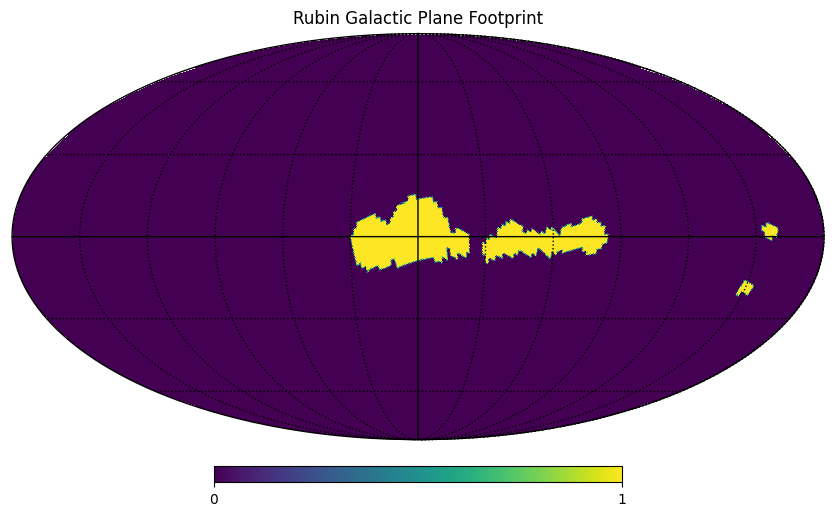

In [17]:
fig = plt.figure(1,(10,10))
hp.mollview(rubin_map, title='Rubin Galactic Plane Footprint')
hp.graticule()
plt.tight_layout()

## HEALpixel coordinates 

Output a list of the l,b for each HEALpixel index

In [22]:
theta, phi = hp.pix2ang(NSIDE, np.arange(0, NPIX, 1, dtype='int'), lonlat=True)
print(theta, phi)

[ 45. 135. 225. ... 135. 225. 315.] [ 89.81725848  89.81725848  89.81725848 ... -89.81725848 -89.81725848
 -89.81725848]


In [27]:
with open('/Users/rstreet/software/rgps/config/healpixel_grid.csv', 'w') as f:
    f.write('HEALpixel_index,l_center_deg,b_center_deg\n')

    for i in range(0, NPIX, 1):
        f.write(str(i) + ',' + str(theta[i]) + ',' + str(phi[i]) + '\n')